In [46]:
import string
import random
import numpy as np
import matplotlib.pyplot as plt

import os
import requests
import re
import textwrap

In [25]:
letters1 = list(string.ascii_lowercase)
letters2 = list(string.ascii_lowercase)

mapPair = {}

random.shuffle(letters2)

for key, value in zip(letters1, letters2):
    mapPair[key] = value

In [32]:
probMatrix = np.ones((26,26))

pi = np.zeros(26)

def update_transition(char1, char2):
    i = ord(char1) - 97
    j = ord(char2) - 97
    probMatrix[i,j] += 1
    
def update_pi(char1):
    i = ord(char1) -97
    pi[i] += 1 
    
def get_word_prob(word):
    i = ord(word[0]) - 97
    logp = np.log(pi[i])
    
    for ch in word[1:]:
        j = ord(ch) - 97
        logp += np.log(M[i,j])
        i = j
        
    return logp

def get_sequence_prob(words):
    
    if type(words) == str:
        words = words.split()
        
    logp = 0
    for word in words:
        logp += get_word_prob(word)
    return logp

In [33]:
if not os.path.exists('moby_dick.txt'):
    print("Downloading moby dick...")
    r = requests.get('https://lazyprogrammer.me/course_files/moby_dick.txt')
    with open('moby_dick.txt', 'w', encoding="utf-8") as f:
        f.write(r.content.decode())

# preprocess data 

In [34]:
regex = re.compile('[^a-zA-Z]')

for line in open('moby_dick.txt', encoding="utf-8"):
    
    line=line.rstrip()
    
    if line:
        line = regex.sub(' ', line)
        
    tokens = line.lower().split()
    
    for token in tokens:
 
       ch0 = token[0]
       update_pi(ch0)
       
       for ch1 in token[1:]:
        update_transition(ch0, ch1)
        ch0=ch1
        
pi /= pi.sum()
probMatrix /= probMatrix.sum(axis=1, keepdims=True)

In [35]:
### encode a message

# this is a random excerpt from Project Gutenberg's
# The Adventures of Sherlock Holmes, by Arthur Conan Doyle
# https://www.gutenberg.org/ebooks/1661

original_message = '''I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was compelled to listen to.
'''

# Away they went, and I was just wondering whether I should not do well
# to follow them when up the lane came a neat little landau, the coachman
# with his coat only half-buttoned, and his tie under his ear, while all
# the tags of his harness were sticking out of the buckles. It hadn't
# pulled up before she shot out of the hall door and into it. I only
# caught a glimpse of her at the moment, but she was a lovely woman, with
# a face that a man might die for.

# My cabby drove fast. I don't think I ever drove faster, but the others
# were there before us. The cab and the landau with their steaming horses
# were in front of the door when I arrived. I paid the man and hurried
# into the church. There was not a soul there save the two whom I had
# followed and a surpliced clergyman, who seemed to be expostulating with
# them. They were all three standing in a knot in front of the altar. I
# lounged up the side aisle like any other idler who has dropped into a
# church. Suddenly, to my surprise, the three at the altar faced round to
# me, and Godfrey Norton came running as hard as he could towards me.

In [39]:
def encode_message(msg):
    
    msg = msg.lower()
    
    msg = regex.sub(' ', msg)
    
    coded_msg = []
    for ch in msg:
        coded_ch = ch
        if ch in mapPair:
            coded_ch = mapPair[ch]
        coded_msg.append(coded_ch)
        
    return ''.join(coded_msg)

encoded_message = encode_message(original_message)

def decode_message(msg, word_map):
    
    decoded_msg = []
    for ch in msg:
        decoded_ch = ch
        if ch in word_map:
            decoded_ch = word_map[ch]
        decoded_msg.append(decoded_ch)
    return ''.join(decoded_msg)

#initialize
dna_pool = []
for _ in range(20):
    dna = list(string.ascii_lowercase)
    random.shuffle(dna)
    dna_pool.append(dna)
    
#evolve algorithm
def evolve_offspring(dna_pool, n_children):
    offspring=[]
    
    for dna in dna_pool:
        for _ in range(n_children):
            copy = dna.copy()
            j = np.random.randint(len(copy))
            k = np.random.randint(len(copy))
            
            temp = copy[j]
            copy[j] = copy[k]
            copy[k] = temp
            offspring.append(copy)
            
        return offspring + dna_pool

num_iters = 1000
scores = np.zeros(num_iters)
best_dna = None
best_map = None
best_score = float('-inf')
for i in range(num_iters):
    if i > 0:
        
        #get offspring from current dna pool
        dna_pool = evolve_offspring(dna_pool, 3)
        
    #calculate score for each dna
    dna2score = {}
    for dna in dna_pool:
        #populate map
        current_map = {}
        for k, v in zip(letters1, dna):
            current_map[k] = v
            
        decoded_message = decode_message(encoded_message, current_map)
        score = get_sequence_prob(decoded_message)
        
        dna2score[''.join(dna)] = score
        
        if score > best_score:
            best_dna = dna
            best_map = current_map
            best_score = score
            
    scores[i] = np.mean(list(dna2score.values()))
    
    sorted_dna = sorted(dna2score.items(), key = lambda x: x[1], reverse=True)
    dna_pool = [list(k) for k, v in sorted_dna[:5]]
    
    if i %200 ==0:
        print("iter:", i, "score:", scores[i], "best so far:", best_score)

iter: 0 score: -387.466458444841 best so far: -321.0903202607339
iter: 200 score: -272.6934199085292 best so far: -257.0690027786224
iter: 400 score: -265.7575190248581 best so far: -257.0690027786224
iter: 600 score: -261.8297825047158 best so far: -256.9712581843353
iter: 800 score: -261.37780986420887 best so far: -256.9712581843353


In [41]:
#use best score
decoded_message = decode_message(encoded_message, best_map)

print("LL of decoded message:", get_sequence_prob(decoded_message))
print("LL of true message:", get_sequence_prob(regex.sub(' ', original_message.lower())))

for true, v in mapPair.items():
    pred = best_map[v]
    if true != pred:
        print("true: %s, pred: %s" % (true, pred))

LL of decoded message: -256.9712581843353
LL of true message: -265.4961359800376
true: a, pred: s
true: b, pred: c
true: c, pred: n
true: d, pred: b
true: e, pred: r
true: f, pred: d
true: g, pred: e
true: i, pred: a
true: j, pred: v
true: k, pred: z
true: l, pred: o
true: m, pred: f
true: n, pred: m
true: o, pred: i
true: p, pred: g
true: q, pred: u
true: r, pred: p
true: s, pred: l
true: u, pred: j
true: v, pred: k
true: x, pred: q
true: y, pred: x
true: z, pred: y


In [44]:
# print the final decoded message
print("Decoded message:\n", textwrap.fill(decoded_message))

print("\nTrue message:\n", original_message)

Decoded message:
 a thrm oijmerb biwm thr ltprrt smb dijmb  sl a rqgrntrb  thst thrpr
wsl s frwl am s osmr whanh pjml biwm cx imr wsoo id thr espbrm  a ormt
thr iltorpl s hsmb am pjccame biwm thrap hiplrl  smb prnrakrb am
rqnhsmer twigrmnr  s eosll id hsod smb hsod  twi daool id lhse ticsnni
smb sl fjnh amdipfstaim sl a nijob brlapr scijt fall sborp  ti lsx
mithame id hsod s biyrm ithrp grigor am thr mraehcijphiib am whif a
wsl mit am thr orslt amtrprltrb  cjt whilr caiepsgharl a wsl nifgroorb
ti oaltrm ti

True message:
 I then lounged down the street and found,
as I expected, that there was a mews in a lane which runs down
by one wall of the garden. I lent the ostlers a hand in rubbing
down their horses, and received in exchange twopence, a glass of
half-and-half, two fills of shag tobacco, and as much information
as I could desire about Miss Adler, to say nothing of half a dozen
other people in the neighbourhood in whom I was not in the least
interested, but whose biographies I was 

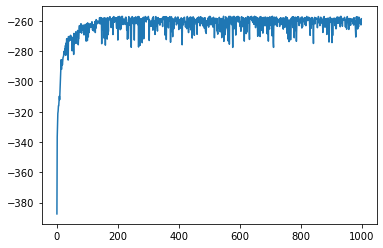

In [47]:
plt.plot(scores)
plt.show()